In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

In [2]:
edges = []
for j in range(9):
    for i in range(9):
        if i < j:
            edges.append((i,j))
print(edges)

weights = [606.5,606.5,606.5,606.5,15.75,15.75,15.75,606.5,15.75,606.5,15.75,15.75,606.5,606.5,606.5,606.5,22.75,22.75,606.5,12,12,22.75,606.5,22.75,12,606.5,12,606.5,22.75,22.75,606.5,12,12,606.5,606.5,606.5]

graph = dict(zip(edges,weights))
print(graph) # all the zz terms and their weights

W = []
for i in range(len(edges)):
    W.append((edges[i][0],edges[i][1],weights[i]))
print(W)

lattice_cite = [i for i in range(9)]
field_str = [-1290,-1290,-1290,-1268.5,-1268.5,-1268.5,-1282.5,-1282.5,-1282.5]
z_terms = dict(zip(lattice_cite,field_str))
print(z_terms) # all the z terms and their weights

[(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (3, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8)]
{(0, 1): 606.5, (0, 2): 606.5, (1, 2): 606.5, (0, 3): 606.5, (1, 3): 15.75, (2, 3): 15.75, (0, 4): 15.75, (1, 4): 606.5, (2, 4): 15.75, (3, 4): 606.5, (0, 5): 15.75, (1, 5): 15.75, (2, 5): 606.5, (3, 5): 606.5, (4, 5): 606.5, (0, 6): 606.5, (1, 6): 22.75, (2, 6): 22.75, (3, 6): 606.5, (4, 6): 12, (5, 6): 12, (0, 7): 22.75, (1, 7): 606.5, (2, 7): 22.75, (3, 7): 12, (4, 7): 606.5, (5, 7): 12, (6, 7): 606.5, (0, 8): 22.75, (1, 8): 22.75, (2, 8): 606.5, (3, 8): 12, (4, 8): 12, (5, 8): 606.5, (6, 8): 606.5, (7, 8): 606.5}
[(0, 1, 606.5), (0, 2, 606.5), (1, 2, 606.5), (0, 3, 606.5), (1, 3, 15.75), (2, 3, 15.75), (0, 4, 15.75), (1, 4, 606.5), (2, 4, 15.75), (3, 4, 606.5), (0, 5, 15.75), (1, 5, 15.75), (2, 5, 

In [3]:
# penalty = 120
lattice_cite_2 = [8,7,6,4,3,2,1,0]
edges_2 = [(7,8), (6,8), (6,7), (5,8), (5,7), (5,6), (4,8), (4,7), (4,6), (4,5), (3,8), (3,7), (3,6), (3,5), (3,4), (2,8), (2,7), (2,6), (2,5), (2,4), (2,3), (1,8), (1,7), (1,6), (1,5), (1,4), (1,3), (1,2), (0,8), (0,7), (0,6), (0,5), (0,4), (0,3), (0,2), (0,1)] 
field_str_2 = [-189.5, -189.5, -189.5, -175.5, -175.5, -175.5, -197.0, -197.0, -197.0]
weights_2 = [ 60.0, 60.0, 60.0, 60.0, 12.0, 12.0, 12.0, 60.0, 12.0, 60.0, 12.0, 12.0, 60.0, 60.0, 60.0, 60.0, 22.75, 22.75, 60.0, 15.75, 15.75, 22.75, 60.0, 22.75, 15.75, 60.0, 15.75, 60.0, 22.75, 22.75, 60.0, 15.75, 15.75, 60.0, 60.0, 60.0]
W_2 = []
for i in range(len(edges_2)):
    W_2.append((edges_2[i][0],edges_2[i][1],weights_2[i]))
graph_2 = dict(zip(edges_2,weights_2))
z_terms_2 = dict(zip(lattice_cite_2,field_str_2))

In [10]:
def create_qaoa_circ_modified(W, theta, field_str):
    """Creates a parametrized qaoa circuit
    Args:
        W: (tuple) containing edges and its respective weights 
        theta: (list) unitary parameters
        z_terms: (dict) containing single z terms and its respective weights
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(field_str)
    #print(nqubits)
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        #problem unitary
        for i in range(nqubits):
            qc.rz(2*gamma[layer_index]*field_str[i],i )
        for pair in W:  # pairs of nodes
            qc.rzz(-2 * gamma[layer_index]*pair[2], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    #qc.measure_all()
    return qc

In [5]:
def energy():

    def execute_circ_1(theta):
        qc = create_qaoa_circ_modified(W_2, theta, field_str_2)
        backend = Aer.get_backend('statevector_simulator')
        job = execute(qc, backend)
        psi_zz = job.result().get_statevector(qc, decimals=8) # this is the state vector of the circuit
    
        Exp_value = []

        for i in range(len(edges_2)):
            qc.z(edges_2[i][0])
            qc.z(edges_2[i][1])
            #qc_1 = create_qaoa_circ_modified(W, theta, field_str_2)
            #for vertices in edges_2[i]: # building the cost hamiltonian
            #    qc.z(vertices)

            job_1 = execute(qc, backend)
            phi_zz = job_1.result().get_statevector(qc, decimals=8)
            Exp_value.append(weights_2[i]*(np.dot(np.transpose(np.conjugate(phi_zz)), psi_zz)))

        qc_z = create_qaoa_circ_modified(W_2, theta, field_str_2)
        job2 = execute(qc_z, backend)

        psi_z  = job2.result().get_statevector(qc_z, decimals=8) # this is the state vector of the circuit
        
        Exp_value_z = []

        for i in range(len(field_str_2)):
            #qc_2 = create_qaoa_circ_modified(W, param, field_str_2)
            qc_z.z(i)
            #backend = Aer.get_backend('statevector_simulator')
            job3 = execute(qc_z, backend)
            phi_z = job3.result().get_statevector(qc_z, decimals=8)
            
            Exp_value_z.append(field_str_2[i]*(np.dot(np.transpose(np.conjugate(phi_z)), psi_z)))
            
        return np.real(np.sum(Exp_value) + (np.sum(Exp_value_z)))
    return execute_circ_1


In [14]:
from scipy.optimize import minimize

#circuit = create_qaoa_circ_modified(W, param, field_str)

#expectation = energy_zzplus_z(circuit)
expectation = energy()
res = minimize(expectation,
               [1.0, 1.0],
               method='SLSQP')
print(res)

     fun: 194.60274422481896
     jac: array([-77.83370399,  84.86598396])
 message: 'Optimization terminated successfully'
    nfev: 137
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-158.6895606 , 1566.65936869])


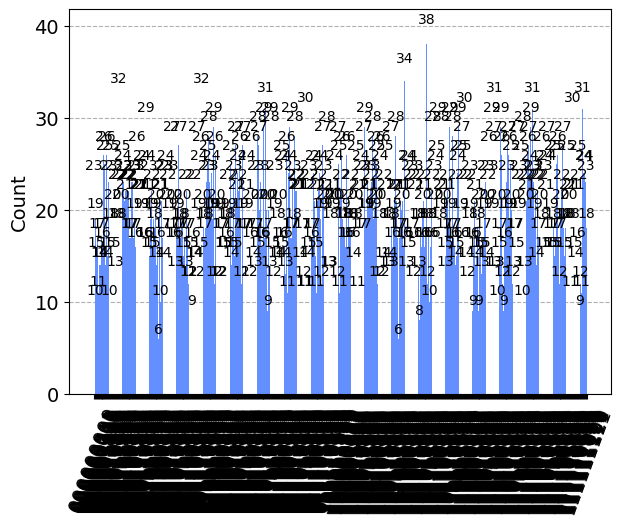

In [15]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 3000

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ_modified(W_2, res.x, field_str_2)
qc_res.measure_all()
counts = backend.run(qc_res, seed_simulator=10,shots=10000).result().get_counts()
plot_histogram(counts)

In [ ]:
# shortcut for commenting out multiple lines of code
# ctrl + / (windows) or cmd + / (mac)

In [17]:
(fun: 194.60274422481896
    jac: array([-77.83370399,  84.86598396])
message: 'Optimization terminated successfully'
    nfev: 137
    nit: 15
    njev: 15
  status: 0
success: True
      x: array([-158.6895606 , 1566.65936869]))

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

In [13]:
for i in range(len(list(counts.values()))):
    if list(counts.values())[i] > 100:
        print(list(counts.keys())[i], list(counts.values())[i])

000111000 134


In [9]:
#-ve ZZ
#energy = -320
#'111110001': 26
# -ve ZZ and X 
# energy = -1100 [1,1,1,1]